# Projet : Detection d’Anomalies dans le Trafic Reseau avec LightGBM

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
import lightgbm as lgb
import optuna
import warnings

# Ignorer tous les warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('data-20221207.csv')

In [6]:
df.shape

(35250, 84)

Dans notre analyse pour detecter les anomalies, nous remarquons que les adresses IP, les ports et les protocoles n'ont pas une importance signifigative sur notre travail. Et, nous allons supprimer tous les variables qui sont tous de types objects.

Pour continuer notre travail et faire du lightGBM, nous allons l'associer avec du IsolationForest pour avoir de bons resultats.

In [7]:
df_clean = df.drop(columns=df.select_dtypes(include=["object"]).columns)

# Détection d'anomalies avec Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_clean['anomaly_score'] = iso_forest.fit_predict(df_clean)

# Création des labels artificiels (1 = anomalie, 0 = normal)
df['Label'] = (df_clean['anomaly_score'] == -1).astype(int)

In [8]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.20.19-54.77.51.148-33118-80-6,192.168.20.19,33118,54.77.51.148,80,6,06/12/2022 11:00:15 PM,36728,5,3,...,20,0,0,0,0,1.670368e+15,1.428227e+04,1.670368e+15,1.670368e+15,1
1,192.168.20.48-108.137.181.26-53948-443-6,192.168.20.48,53948,108.137.181.26,443,6,06/12/2022 11:00:51 PM,890408,17,16,...,32,0,0,0,0,1.670368e+15,1.818134e+05,1.670368e+15,1.670368e+15,0
2,192.168.20.43-34.232.93.236-58752-443-6,192.168.20.43,58752,34.232.93.236,443,6,06/12/2022 11:01:19 PM,3777984,13,13,...,32,0,0,0,0,1.670368e+15,3.286600e+05,1.670368e+15,1.670368e+15,1
3,192.168.20.43-54.70.5.180-46084-443-6,192.168.20.43,46084,54.70.5.180,443,6,06/12/2022 11:01:25 PM,8672390,17,16,...,32,0,0,0,0,1.670368e+15,1.159272e+06,1.670368e+15,1.670368e+15,0
4,192.168.20.15-255.255.255.255-49156-6666-17,192.168.20.15,49156,255.255.255.255,6666,17,06/12/2022 11:00:02 PM,116995737,40,0,...,8,0,0,0,0,1.670368e+15,3.333902e+07,1.670368e+15,1.670368e+15,0


## Analyse des donnees

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35250 entries, 0 to 35249
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            35250 non-null  object 
 1   Src IP             35250 non-null  object 
 2   Src Port           35250 non-null  int64  
 3   Dst IP             35250 non-null  object 
 4   Dst Port           35250 non-null  int64  
 5   Protocol           35250 non-null  int64  
 6   Timestamp          35250 non-null  object 
 7   Flow Duration      35250 non-null  int64  
 8   Tot Fwd Pkts       35250 non-null  int64  
 9   Tot Bwd Pkts       35250 non-null  int64  
 10  TotLen Fwd Pkts    35250 non-null  float64
 11  TotLen Bwd Pkts    35250 non-null  float64
 12  Fwd Pkt Len Max    35250 non-null  float64
 13  Fwd Pkt Len Min    35250 non-null  float64
 14  Fwd Pkt Len Mean   35250 non-null  float64
 15  Fwd Pkt Len Std    35250 non-null  float64
 16  Bwd Pkt Len Max    352

## Analyse Descriptive

In [10]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,35250.000000,35250.000000,35250.000000,3.525000e+04,35250.000000,35250.000000,3.525000e+04,3.525000e+04,35250.000000,35250.000000,...,35250.000000,35250.0,35250.0,35250.0,35250.0,3.525000e+04,3.525000e+04,3.525000e+04,3.525000e+04,35250.000000
mean,32725.215773,4093.957135,9.654014,5.863364e+07,10.557645,7.305986,1.586903e+03,4.268761e+03,143.844766,38.786638,...,17.934525,0.0,0.0,0.0,0.0,1.121376e+15,4.242112e+13,1.141281e+15,1.029683e+15,0.049986
std,21034.118608,9286.531925,6.038117,4.878321e+07,35.308917,203.282570,1.416406e+04,2.860409e+05,261.923888,79.460542,...,11.908453,0.0,0.0,0.0,0.0,7.703030e+14,1.772714e+14,7.771114e+14,8.122588e+14,0.217919
min,0.000000,0.000000,0.000000,3.900000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,9999.000000,53.000000,6.000000,2.550325e+04,2.000000,0.000000,2.700000e+01,0.000000e+00,11.000000,0.000000,...,8.000000,0.0,0.0,0.0,0.0,5.999839e+07,0.000000e+00,5.999839e+07,5.000311e+06,0.000000
50%,40530.000000,443.000000,6.000000,6.487975e+07,4.000000,1.000000,6.600000e+01,2.800000e+01,40.000000,0.000000,...,20.000000,0.0,0.0,0.0,0.0,1.670384e+15,2.958461e+07,1.670390e+15,1.670384e+15,0.000000
75%,50358.500000,5228.000000,17.000000,1.078150e+08,10.000000,4.000000,5.910000e+02,1.380000e+02,180.000000,40.000000,...,32.000000,0.0,0.0,0.0,0.0,1.670418e+15,3.597575e+07,1.670421e+15,1.670418e+15,0.000000
max,65519.000000,60964.000000,17.000000,1.200000e+08,2901.000000,21068.000000,1.179094e+06,2.968596e+07,1460.000000,379.000000,...,44.000000,0.0,0.0,0.0,0.0,1.670453e+15,1.181188e+15,1.670453e+15,1.670453e+15,1.000000


## Detection des valeurs manquantes

In [11]:
df.isnull().sum().reset_index().T

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
index,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
print('The total number of missing value: ', df.isnull().sum().sum())

The total number of missing value:  0


## Visualition de la distribution des donnees && Detection des valeurs aberrantes

In [ ]:
import time #(cellule non executer. Prend trop de temps)
# Échantillonnage des données (utiliser 10% des données)
df_sample = df.sample(frac=0.1, random_state=42)

"""
# Fonction pour créer les graphiques
def plot_variable(col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.histplot(df_sample[col], ax=axes[0])
    sns.boxplot(df_sample[col], ax=axes[1], showmeans=True)
    plt.title(col)
    plt.show()
"""
# Sélectionner les colonnes numériques
numeric_cols = df_sample.select_dtypes('number').columns
"""
# Mesurer le temps d'exécution
start_time = time.time()

# Traitement par lots
batch_size = 10  # Nombre de colonnes à traiter par lot
for i in range(0, len(numeric_cols), batch_size):
    batch_cols = numeric_cols[i:i+batch_size]
    Parallel(n_jobs=-1)(delayed(plot_variable)(col) for col in batch_cols)

end_time = time.time()

execution_time = end_time - start_time
print(f"Temps d'exécution : {execution_time} secondes")
"""

## Analyse des correlations

In [13]:
def get_high_correlation_features(df, target_column):
        """
        Retourne les colonnes corrélées à la variable cible avec un coefficient de corrélation
        supérieur à 0.5 ou inférieur à -0.5.

        Returns:
        --------
        high_corr_features : list
            Liste des noms de colonnes corrélées à la variable cible.
        """
        correlation_matrix = df.corr(numeric_only=True)
        target_corr = correlation_matrix[target_column]
        high_corr_features = target_corr[(target_corr > 0.5) | (target_corr < -0.5)].index.tolist()
        high_corr_features.remove(target_column)
        return high_corr_features

In [14]:
get_high_correlation_features(df, 'Label')

['Fwd Pkt Len Max',
 'Fwd Pkt Len Mean',
 'Fwd Pkt Len Std',
 'Pkt Len Max',
 'Pkt Len Mean',
 'Pkt Len Std',
 'Pkt Len Var',
 'Pkt Size Avg',
 'Fwd Seg Size Avg']

## Etude explorative de la variable cible

Text(0.5, 1.0, 'Exploration de la variable cible')

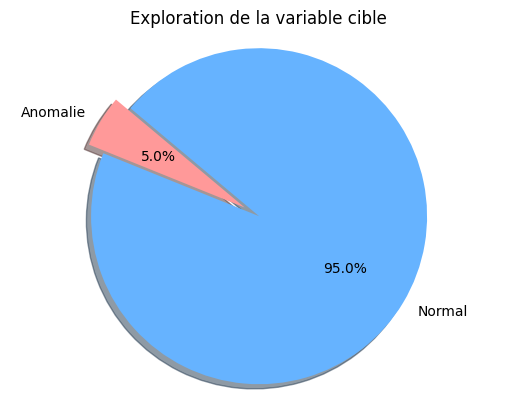

In [15]:
# Compter les occurrences de chaque catégorie
counts = df['Label'].value_counts()

# Préparer les données pour le diagramme circulaire
labels = ['Anomalie', 'Normal']
sizes = [counts[1], counts[0]]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)

# Créer le diagramme circulaire
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)

plt.axis('equal')  # Assure que le diagramme est dessiné en cercle.
plt.title('Exploration de la variable cible')

## Preprocessing 

In [16]:
class DataPreprocessor:
    """
    Prétraitement des Données

    • Nettoyage : Imputer les valeurs manquantes.
    • Encodage des variables catégorielles : Appliquer l’encodage par variables factices (dummy variables)
      pour les données non numériques.
    • Standardisation : Standardiser les données numériques pour améliorer les performances des algorithmes.
    • Livrable : Code et documentation du pipeline de prétraitement des données.

    Attributes:
    -----------
    df : pd.DataFrame
        Le DataFrame contenant les données à traiter.
    target_column : str
        La colonne cible pour le modèle.
    exclude_columns : list
        Les colonnes à exclure du prétraitement (par défaut, aucune colonne n'est exclue).
    test_size : float
        La proportion de l'ensemble de test (par défaut, 0.2).
    random_state : int
        Graine aléatoire pour la reproductibilité du découpage en train/test (par défaut, 0).
    """
    
    def __init__(self, df, target_column, exclude_columns=None, test_size=0.2, random_state=0):
        
        self.df = df
        self.target_column = target_column
        self.exclude_columns = exclude_columns if exclude_columns is not None else []
        self.test_size = test_size
        self.random_state = random_state


    def impute_outliers(self, colname): 
        q1 = np.percentile(self.df[colname], 25)
        q3 = np.percentile(self.df[colname], 75) 

        lower_bound = q1 - 1.5*(q3 - q1)
        upper_bound = q3 + 1.5*(q3 - q1)

        self.df.loc[(self.df[colname] <= lower_bound), colname] = lower_bound
        self.df.loc[(self.df[colname] >= upper_bound), colname] = upper_bound

    def preprocess_data(self):
        """
        Impute les valeurs aberrantes pour toutes les colonnes numériques.
        """
        for colname in self.df.select_dtypes('number').columns:
            self.impute_outliers(colname)
        

    def split_data(self):
        """
        Divise les données en ensembles d'entraînement et de test.

        Returns:
        --------
        X_train, X_test, y_train, y_test : tuple
            Données divisées en ensembles d'entraînement et de test.
        """
        y = self.df[self.target_column]
        X = self.df.drop([self.target_column] + self.exclude_columns, axis='columns')
        
        X_train, X_test, y_train, y_test = train_test_split(
                                 X, 
                                 y, 
                                 test_size=self.test_size, 
                                 random_state=self.random_state
                            )
        return X_train, X_test, y_train, y_test
    
    

    def create_pipeline(self, X_train):
        """
        Crée un pipeline de prétraitement pour les données.

        Étapes du pipeline :
        - Imputation des valeurs manquantes.
        - Standardisation des colonnes numériques.
        - Encodage des variables catégorielles avec des variables factices.

        Parameters:
        -----------
        X_train : pd.DataFrame
            Données d'entraînement pour déterminer les types de colonnes.

        Returns:
        --------
        full_pipeline : ColumnTransformer
            Pipeline de transformations pour le prétraitement complet des données.
        """
        num_cols = X_train.select_dtypes(include=['number']).columns
        cat_cols = X_train.select_dtypes(include='object').columns
        num_pipeline = make_pipeline(
                    SimpleImputer(strategy='median'),
                    StandardScaler(),
                )
        cat_pipeline = make_pipeline(
                    SimpleImputer(strategy='most_frequent'),
                    OneHotEncoder(handle_unknown='ignore', drop='first')
                )
        full_pipeline = ColumnTransformer([
                            ('num', num_pipeline, num_cols),
                            ('cat', cat_pipeline, cat_cols)
                        ])
        return full_pipeline

In [17]:
preprocessing = DataPreprocessor(df, 'Label',['Flow ID','Src IP','Src Port'	,'Dst IP','Dst Port','Protocol','Timestamp'],random_state=10)
X_train, X_test, y_train, y_test = preprocessing.split_data()
pipeline = preprocessing.create_pipeline(X_train)

In [18]:
X_train_transform = pipeline.fit_transform(X_train)
X_test_transform = pipeline.transform(X_test)

In [19]:
# Pipeline avec SMOTE et LightGBM
pipeline = ImbPipeline(steps=[
    ('equilibrage_classes', SMOTE(sampling_strategy='auto', random_state=42)),  # Gestion du déséquilibre des classes
    ('modele', lgb.LGBMClassifier())  # Modèle LightGBM
])

In [ ]:
# Optimisation des hyperparamètres avec GridSearchCV #(cellule non executer. Prend trop de temps)
grille_parametres = {
    'modele__num_leaves': [31, 50, 70],
    'modele__learning_rate': [0.01, 0.1, 0.2],
    'modele__n_estimators': [100, 200, 300]
}

recherche_grille = GridSearchCV(pipeline, grille_parametres, cv=5, scoring='f1', verbose=2, n_jobs=-1)
recherche_grille.fit(X_train_transform, y_train)

print("Meilleurs paramètres GridSearchCV :", recherche_grille.best_params_)

In [ ]:
# Optimisation des hyperparamètres avec Optuna #(cellule non executer. Prend trop de temps)
def fonction_objectif(essai):
    parametres = {
        'num_leaves': essai.suggest_int('num_leaves', 20, 100),
        'learning_rate': essai.suggest_loguniform('learning_rate', 0.001, 0.1),
        'n_estimators': essai.suggest_int('n_estimators', 50, 300)
    }
    modele_lightgbm = lgb.LGBMClassifier(**parametres)
    
    pipeline_optuna = ImbPipeline(steps=[
        ('equilibrage_classes', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE
        ('modele', modele_lightgbm)  # Modèle optimisé
    ])
    
    pipeline_optuna.fit(X_train_transform, y_train)
    return pipeline_optuna.score(X_test, y_test)

etude = optuna.create_study(direction='maximize')
etude.optimize(fonction_objectif, n_trials=20)

print("Meilleurs paramètres Optuna :", etude.best_params)

In [20]:
pipeline.fit(X_train_transform, y_train)

[LightGBM] [Info] Number of positive: 26807, number of negative: 26807
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14528
[LightGBM] [Info] Number of data points in the train set: 53614, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


Pipeline(steps=[('equilibrage_classes', SMOTE(random_state=42)),
                ('modele', LGBMClassifier())])

In [21]:
pipeline

Pipeline(steps=[('equilibrage_classes', SMOTE(random_state=42)),
                ('modele', LGBMClassifier())])

In [22]:
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, roc_auc_score, roc_curve, 
                             precision_recall_curve, classification_report)

#Évaluation du modèle LightGBM
print("Évaluation du modèle LightGBM")
y_pred = pipeline.predict(X_test_transform)
y_proba = pipeline.predict_proba(X_test_transform)[:, 1]  # Probabilités pour AUC-ROC

Évaluation du modèle LightGBM


In [23]:
# Calcul des métriques
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

# Affichage des résultats
print(f"Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, AUC-ROC: {auc:.3f}")
print("Matrice de confusion :\n", cm)



Précision: 0.930, Recall: 0.967, F1-score: 0.948, AUC-ROC: 0.999
Matrice de confusion :
 [[6654   27]
 [  12  357]]


Parmis les predictions positives, 93% sont correctes (precision);  
96.7% de vrais positifs existant sont détectés(Recall);  
Le modele detecte correctement les anomalies à 94.8%(f1-score);  
Le modele 99.9% de chance de classer correctement une instance aléatoire positive contre une instance negative(AUC-ROC).

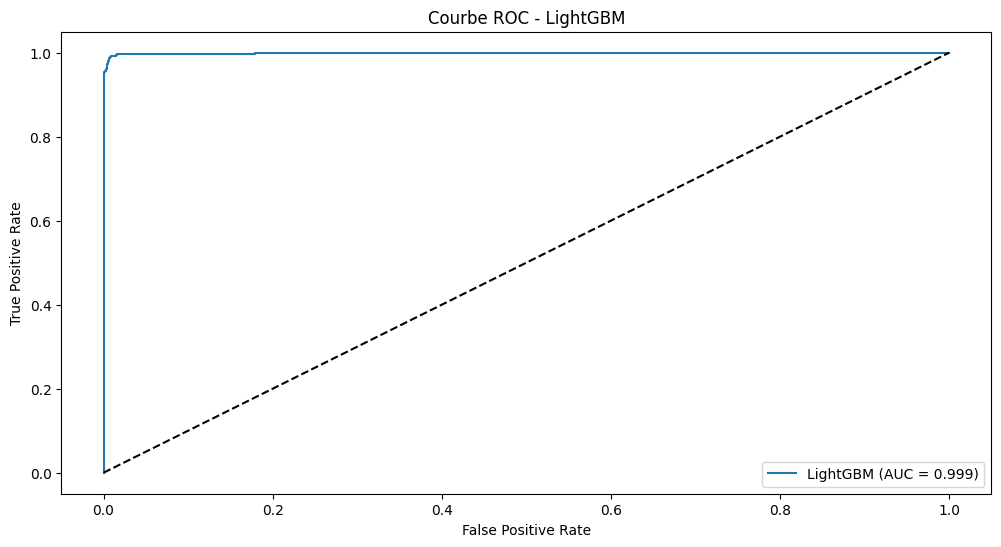

In [24]:
#Courbes ROC et PR
plt.figure(figsize=(12, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC - LightGBM')
plt.legend()
plt.show()


La courbe est sur le point (0,1) et au dessus de la diagonale, c'est donc un tres bon classificateur

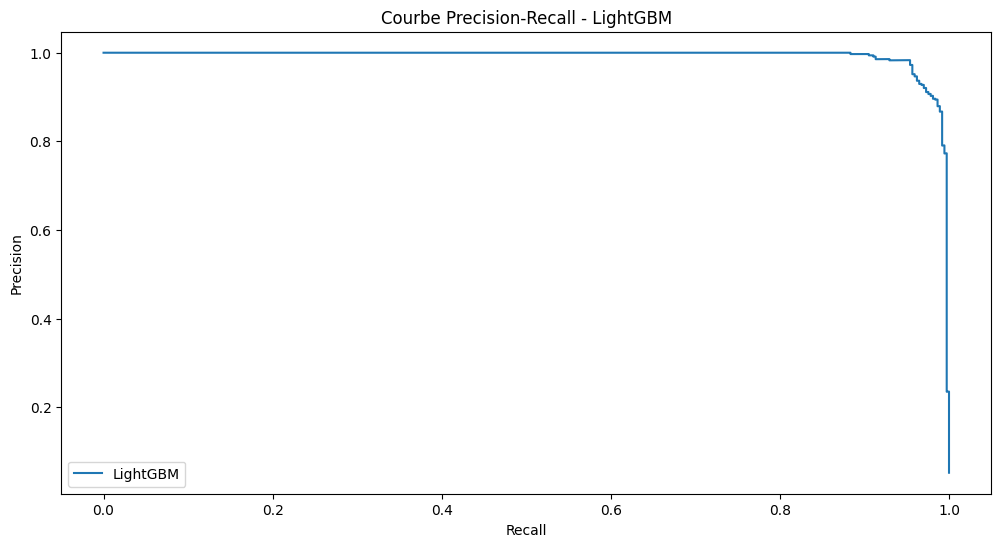

In [25]:
# PR Curve
plt.figure(figsize=(12, 6))
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall_vals, precision_vals, label='LightGBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Courbe Precision-Recall - LightGBM')
plt.legend()
plt.show()

Le modèle parvient à maintenir une bonne précision même lorsque le rappel augmente.

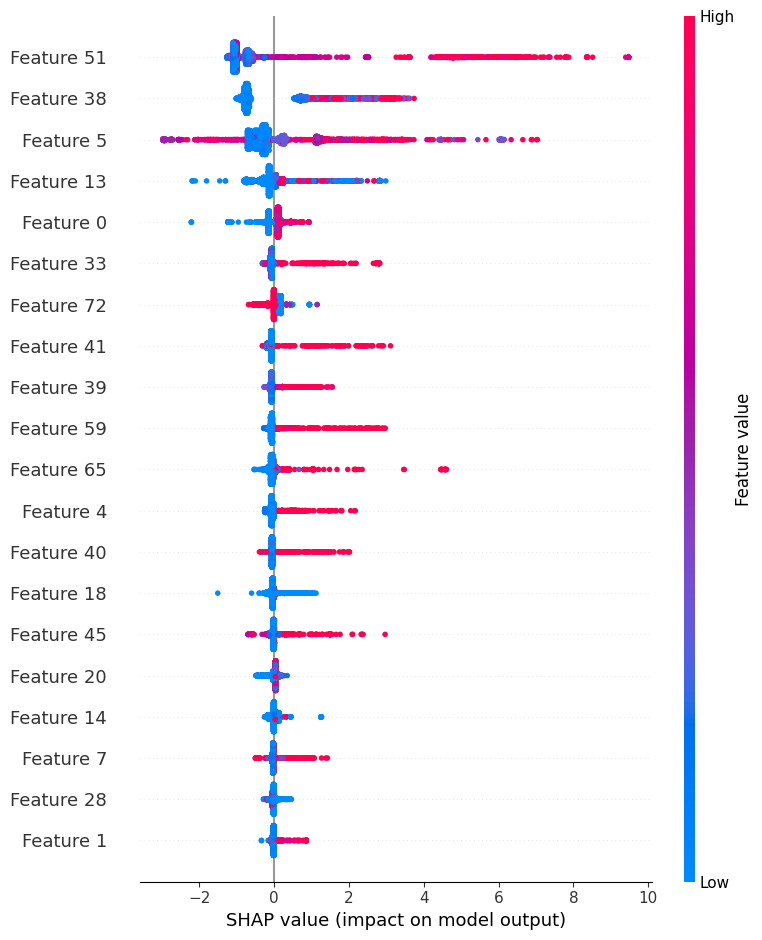

In [32]:


#SHAP pour interprétation des prédictions (pour la classe 1 = anomalie)

# 1️⃣ Récupération du modèle entraîné dans le pipeline
best_model = pipeline.named_steps["modele"]

# 2️⃣ Vérification des colonnes
assert X_train_transform.shape[1] == X_test_transform.shape[1], "Les dimensions des features ne correspondent pas !"

# 3️⃣ Création de l'explicateur SHAP
explainer = shap.Explainer(best_model, X_train_transform)

# 4️⃣ Génération des valeurs SHAP avec additivity check désactivé
shap_values = explainer(X_test_transform, check_additivity=False)

# 5️⃣ Affichage des résultats SHAP
shap.summary_plot(shap_values, X_test_transform)


Ce graphe permet d’interpréter l'impact de chaque variable sur la prédiction d’un modèle (en l'occurence ici les anomalies).

Ici les features sont classés par ordre d'importance d'influence sur la prédiction et les 20 features listés sont les 20 les plus importantes.

La feature 51 ici a le plus d'importante dans la prédiction des anomalies. 
Dans ce graphe, les valeurs les plus fortes (en rouge) augmentent fortement en général la probabilité d'avoir une anomalie et les observations les plus faibles (en bleu) ont une faible influence sur la probabilité voir pas du tout en général d'avoir une anomalie.

In [33]:
#Comparaison avec XGBoost, Random Forest, Logistic Regression
models = {
    "XGBoost": ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    "Random Forest": ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('model', RandomForestClassifier(random_state=42))]),
    "Logistic Regression": ImbPipeline(steps=[('smote', SMOTE(random_state=42)), ('model', LogisticRegression(random_state=42))])
}

results = {}

for name, model in models.items():
    print(f"\n Évaluation du modèle {name}")
    model.fit(X_train_transform, y_train)
    y_pred = model.predict(X_test_transform)
    y_proba = model.predict_proba(X_test_transform)[:, 1]
    
    # Calcul des métriques
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    results[name] = {"precision": precision, "recall": recall, "f1-score": f1, "AUC-ROC": auc, "confusion_matrix": cm}
    
    print(f"Précision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}, AUC-ROC: {auc:.3f}")
    print("Matrice de confusion :\n", cm)




 Évaluation du modèle XGBoost
Précision: 0.914, Recall: 0.981, F1-score: 0.946, AUC-ROC: 1.000
Matrice de confusion :
 [[6647   34]
 [   7  362]]

 Évaluation du modèle Random Forest
Précision: 0.885, Recall: 0.984, F1-score: 0.932, AUC-ROC: 1.000
Matrice de confusion :
 [[6634   47]
 [   6  363]]

 Évaluation du modèle Logistic Regression
Précision: 0.708, Recall: 0.995, F1-score: 0.828, AUC-ROC: 0.999
Matrice de confusion :
 [[6530  151]
 [   2  367]]


En comparant le modele avec XGBoost, Random Forest et la Regression logistique : On constate que sur la précision Lightgbm domine avec 93%;  
Sur le Recall c'est la regression logistique qui domine avec 99.5%;   
C'est lightgbm avec 94.8%;  
Et enfin sur AUC-ROC Random forest et XGBoost sont en tete avec 100%